In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

pd.options.display.max_columns = 100

In [177]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

In [178]:
# Подбор лучших параметров модели
def search_best_params(a_X_train, a_y_train):
    
    parameters = [{'n_estimators': [50, 100, 200, 300, 400, 500], 
                   'max_features': np.arange(3, 8),
                   'random_state': [10, 21, 42]
                  }]

    gscv = GridSearchCV(estimator = RandomForestRegressor(criterion = 'mse'),
                       param_grid = parameters, 
                       scoring = 'r2', 
                       cv = 4,
                       n_jobs = -1)

    gscv.fit(a_X_train, a_y_train)

    print(f'Лучшие параметры: {gscv.best_params_}\n')
    
    means = gscv.cv_results_['mean_test_score']
    stds  = gscv.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, gscv.cv_results_['params']):
        print('\t%0.6f (+/-%0.06f) for %r'%(mean, std, params))

In [179]:
# Оценка прогноза
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    r2_train = round(r2_score(y_train, y_train_preds), 6)
    r2_test  = round(r2_score(y_test, y_test_preds), 6)
    
#     print('R2 Train =', r2_train)
#     print('R2 Test  =', r2_test)
    
    plt.figure(figsize = (11, 7))
    
    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values, color = 'steelblue')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title(f'Train sample prediction (R2 = {r2_train:6})')
    
    plt.subplot(122)
    sns.scatterplot(x = test_pred_values, y = test_true_values, color = 'darkblue')

    plt.subplots_adjust(wspace = 0.15)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title(f'Test sample prediction (R2 = {r2_test:6})')
    
    plt.show()

In [180]:
# кросс валидация - проверка полученной модели с помощью скользящего контроля
def cross_validation_check(a_model, a_X, a_y, a_score, a_n_splits, a_random_state):

    cv_score = cross_val_score(estimator = a_model, 
                               X = a_X, 
                               y = a_y, 
                               scoring = a_score, 
                               cv = KFold(n_splits = a_n_splits, shuffle = True, random_state = a_random_state), 
                               n_jobs = -1)
#     print(cv_score)
    mean = round(cv_score.mean(), 6) 
        
    df_cv_score = pd.DataFrame(cv_score, columns = ['R2'])
    df_cv_score['Mean'] = df_cv_score['R2'].mean()

    sns.set(style="whitegrid", color_codes=True, font_scale = 1)

    fig, ax = plt.subplots( nrows = 1, ncols = 1)
    ax1 = ax
    
    fig.set_size_inches(7, 5)
#     ax1.set_ylim([0.65, 1.0])

    sns.barplot(x = df_cv_score.index, y = 'R2', data = df_cv_score, color = 'steelblue');

    Xi = 0
    for Yi in df_cv_score['R2']:
        t = plt.text(Xi, Yi, round(Yi, 6), horizontalalignment = 'center', verticalalignment = 'bottom', 
                     fontsize = 13,  weight = 'bold')
        Xi += 1

    # R2 среднее значение
    plt.plot(df_cv_score.index, df_cv_score['Mean'], label = 'Mean', linestyle='--', linewidth=4, color = 'red')

    plt.title('Cross validation (R2)', fontsize = 16, weight = 'bold')
    plt.xlabel('Test', fontsize = 12, weight = 'bold')
    plt.ylabel('R2', fontsize = 12, weight = 'bold')
    
#     plt.legend(loc = 'lower right', fontsize = 12, title = f'Mean R2 = {mean}')
    plt.legend(loc = 'center', fontsize = 12, title = f'Mean R2 = {mean}')

    return df_cv_score

In [181]:
# Важность признаков
def show_features_importance(a_X, a_feature_importances):
    
#     feature_importances = pd.DataFrame(zip(X_train_scaled.columns, model.feature_importances_), 
#                                        columns=['Feature', 'Importance'])
    feature_importances = pd.DataFrame(zip(a_X.columns, a_feature_importances), 
                                       columns=['Feature', 'Importance'])

    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    # 
    sns.set(style="whitegrid", color_codes=True, font_scale = 1)

    fig, ax = plt.subplots()
    fig.set_size_inches(9, 7)

    sns.barplot(x = feature_importances['Importance'], y = feature_importances['Feature'], data = feature_importances)
    # 
    Yi = 0
    for Xi, value in zip(feature_importances['Importance'], feature_importances['Importance']):
        t = plt.text(Xi, Yi, round(value, 4), verticalalignment = 'center', fontsize = 10,  weight = 'bold')
        Yi += 1

    plt.title('Feature Importance', fontsize = 16, weight = 'bold')
    plt.xlabel('Importance', fontsize = 12, weight = 'bold')
    plt.ylabel('Features', fontsize = 12, weight = 'bold')
    
    plt.show()
    
    return feature_importances

In [182]:
def new_params(df):    
    
    df_med_price_by_weight_param = df.groupby(['WeightParam'], as_index = False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByWeightParam'})

    df = df.merge(df_med_price_by_weight_param, on = ['WeightParam'], how = 'left')

    return df

In [183]:
def data_prepare(df):
    
    #-------------------------------------------------------------------------------------
    # print('Признак Id объекта использую в качестве индекса')
    # Признак Id объекта использую в качестве индекса
    
    # df.set_index('Id')

    #-------------------------------------------------------------------------------------
    # Признак Rooms, заменяю нулевые значения Rooms на медиану
    #-------------------------------------------------------------------------------------
    
    print('\nПризнак Rooms:\n\t заменяю сомнительные значения Rooms (больше 10) на медиану')

    me = df['Rooms'].median()
    df.loc[df['Rooms'] >= 10, 'Rooms'] = me

    #-------------------------------------------------------------------------------------
    # Признак HouseYear, заменяю значения года больше текущего (2020) на медиану
    #-------------------------------------------------------------------------------------
    
    print(f'\nПризнак HouseYear:\n\t заменяю значения года больше текущего (2020) на медиану')

    me = df.loc[df['HouseYear'] <= 2020, 'HouseYear'].median()
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = me

    #-------------------------------------------------------------------------------------
    # Признаки Floor, HouseFloor
    #-------------------------------------------------------------------------------------
    
    # Заменяю ошибочные значения (HouseFloor), 
    # где этаж квартиры выше этажности самого дома (Floor > HouseFloor) на этаж квартиры (Floor)
    
    print(f'\nПризнаки Floor, HouseFloor:')
    print(f'\tЗаменяю ошибочные значения (HouseFloor), где (Floor > HouseFloor) на сам этаж квартиры (Floor)')

    df.loc[ df['Floor'] > df['HouseFloor'], 'HouseFloor'] = df['Floor']
   
    #-------------------------------------------------------------------------------------
    # Признаки Square, LifeSquare, KitchenSquare
    #-------------------------------------------------------------------------------------

    # Ввожу новые признаки - Отношение Жилой площади и Площади кухни к общей площади 
    # Rate_Square_Life_to_Total    = LifeSquare    / Square
    # Rate_Square_Kitchen_to_Total = KitchenSquare / Square
    
    print('\nПризнаки Square, LifeSquare, KitchenSquare:')

    print('\tВвожу новые вспомогательные признаки:\
                \n\t\t- Rate_Square_Life_to_Total    = LifeSquare    / Square\
                \n\t\t- Rate_Square_Kitchen_to_Total = KitchenSquare / Square')
    
    df['Rate_Square_Life_to_Total']    = df['LifeSquare']    / df['Square']
    df['Rate_Square_Kitchen_to_Total'] = df['KitchenSquare'] / df['Square']

    # Считаю, что данные по общей площади (Square) более точные, 
    # чем по жилой площади (LifeSquare) и площади кухни (KitchenSquare)
    # Поэтому все уточняющие расчеты веду относительно общей площади (Square)

    #-------------------------------------------------------------------------------------
    # Признак KitchenSquare
    #-------------------------------------------------------------------------------------
    
    # Для квартир, где площадь кухни больше 70% общей площади (т.е. Rate_Square_Kitchen_to_Total > 0.7)
    # заменяю значения KitchenSquare произведением общей площади (Square) на медианную долю площади кухни
    # т.е. KitchenSquare = Square * me_Square_Kitchen_to_Total

    # Считаю медиану me_Square_Kitchen_to_Total (для корректных площадей, где Square > LifeSquare + KitchenSquare)
    
    me_Rate_Square_Kitchen_to_Total = (df.loc[ df['Square'] > df['LifeSquare'] + df['KitchenSquare'], 
                                               'Rate_Square_Kitchen_to_Total']).median()

    print(f'\tМедиана Rate_Square_Kitchen_to_Total = {me_Rate_Square_Kitchen_to_Total}')

    df.loc[ df['Rate_Square_Kitchen_to_Total'] > 0.7, 'KitchenSquare'] = df['Square'] * me_Rate_Square_Kitchen_to_Total

    # И также пересчитываю Rate_Square_Kitchen_to_Total (уже по новым данным)
    
    df['Rate_Square_Kitchen_to_Total'] = df['KitchenSquare'] / df['Square']

    #-------------------------------------------------------------------------------------
    # Признак LifeSquare
    #-------------------------------------------------------------------------------------

    # Замена пустых значений (LifeSquare) на произведение общей площади (Square) и медианной доли жилой площади,
    # т.е. LifeSquare = Square * me_Rate_Square_Life_to_Total

    # Считаю медиану me_Rate_Square_Life_to_Total (для корректных площадей, где Square > LifeSquare + KitchenSquare)
    me_Rate_Square_Life_to_Total = (df.loc[ df['Square'] > df['LifeSquare'] + df['KitchenSquare'], 
                                               'Rate_Square_Life_to_Total']).median()

    print(f'\tМедиана Rate_Square_Life_to_Total    = {me_Rate_Square_Life_to_Total}')

    # Сразу заменяю LifeSquare с пустыми значениями и значения, где доля жилой площади больше площади всей квартиры
    
    df.loc[ (df['LifeSquare'].isnull()) |
                  (df['Rate_Square_Life_to_Total'] > 1.0), 'LifeSquare'] = \
                    df['Square'] * me_Rate_Square_Life_to_Total

    # И также пересчитываю Rate_Square_Life_to_Total (уже по новым данным)
    
    df['Rate_Square_Life_to_Total'] = df['LifeSquare'] / df['Square']

    #-------------------------------------------------------------------------------------
    # Заменяю LifeSquare и KitchenSquare произведениями их медианных долей на общую площадь квартиры
    #-------------------------------------------------------------------------------------

    # Если еще остались ошибочные значения площадей, где Square < LifeSquare + KitchenSquare
    # Также можно считать выбросами площадь квартир менее 5 м2, то провожу следующие преобразования

    # 1) Новая медиана me_Rate_Square_Life_to_Total
    
    me_Rate_Square_Life_to_Total = (df.loc[ df['Square'] > df['LifeSquare'] + df['KitchenSquare'], 
                                               'Rate_Square_Life_to_Total']).median()

    # 2) Новая медиана me_Square_Kitchen_to_Total
    
    me_Rate_Square_Kitchen_to_Total = (df.loc[ df['Square'] > df['LifeSquare'] + df['KitchenSquare'], 
                                               'Rate_Square_Kitchen_to_Total']).median()

#     print(f'Медиана Rate_Square_Life_to_Total    = {me_Rate_Square_Life_to_Total}')
#     print(f'Медиана Rate_Square_Kitchen_to_Total = {me_Rate_Square_Kitchen_to_Total}')

    # 3) Замена значений LifeSquare и KitchenSquare через новые столбцы
    
    df['Square_1']        = df['Square']
    df['LifeSquare_1']    = df['LifeSquare']
    df['KitchenSquare_1'] = df['KitchenSquare']

    # 4) Сначала замена некорректных площадей, где Square < LifeSquare + KitchenSquare
    
    df.loc[ df['Square'] < df['LifeSquare_1'] + df['KitchenSquare_1'], 'LifeSquare'] = \
                    df['Square'] * me_Rate_Square_Life_to_Total

    df.loc[ df['Square'] < df['LifeSquare_1'] + df['KitchenSquare_1'], 'KitchenSquare'] = \
                    df['Square'] * me_Rate_Square_Kitchen_to_Total

    # 5) Затем замена малых площадей (менее 6 м2)
    print('\n\tЗамена площадей (менее 6 м2)')
    
    df.loc[ df['Square'] <= 6, 'Square']        = 6
    df.loc[ df['Square'] <= 6, 'LifeSquare']    = 6 * me_Rate_Square_Life_to_Total
    df.loc[ df['Square'] <= 6, 'KitchenSquare'] = 6 * me_Rate_Square_Kitchen_to_Total

    #-------------------------------------------------------------------------------------
    # 6) Заменяю 1-й и 99-й % значения площадей на их медианы 
    #-------------------------------------------------------------------------------------
#     print('\n\tЗамена 1-го и 99-го % значения площадей на их медианы')
          
#     me_Square        = df['Square'].median()
#     me_LifeSquare    = df['LifeSquare'].median()
#     me_KitchenSquare = df['KitchenSquare'].median()
    
#     print(f'\t\tМедиана Square        = {me_Square}')
#     print(f'\t\tМедиана LifeSquare    = {me_LifeSquare}')
#     print(f'\t\tМедиана KitchenSquare = {me_KitchenSquare}')
    
#     df.loc[ (df['Square'] < df['Square'].quantile(.01)) |
#                 (df['Square'] > df['Square'].quantile(.99)), 'Square'] = me_Square
    
#     df.loc[ (df['LifeSquare'] < df['LifeSquare'].quantile(.01)) |
#                 (df['LifeSquare'] > df['LifeSquare'].quantile(.99)), 'LifeSquare'] = me_LifeSquare
    
#     df.loc[ (df['KitchenSquare'] < df['KitchenSquare'].quantile(.01)) |
#                 (df['KitchenSquare'] > df['KitchenSquare'].quantile(.99)), 'KitchenSquare'] = me_KitchenSquare

    # 7) Удаление вспомогательных столбцов
    
    df = df.drop('Square_1',        axis = 1)
    df = df.drop('LifeSquare_1',    axis = 1)
    df = df.drop('KitchenSquare_1', axis = 1)

    # 8) Еще раз пересчитываю Rate_Square_Life_to_Total и Rate_Square_Kitchen_to_Total (уже по новым данным)
    
    df['Rate_Square_Life_to_Total']    = df['LifeSquare']    / df['Square']
    df['Rate_Square_Kitchen_to_Total'] = df['KitchenSquare'] / df['Square']

    #-------------------------------------------------------------------------------------
    # Признак Healthcare_1, Логика признака Healthcare_1 непонятна - Заполняю пустые значения Healthcare_1 медианой
    #-------------------------------------------------------------------------------------
    
    print('\nПризнак Healthcare_1\
            \n\tЛогика признака непонятна - заполняю пустые значения Healthcare_1 медианой')

    Healthcare_1_median = df['Healthcare_1'].median()
    df['Healthcare_1'] = df['Healthcare_1'].fillna(Healthcare_1_median)

    #-------------------------------------------------------------------------------------
    # Категориальные переменные, Dtype = object (Ecology_2, Ecology_3, Shops_2)
    #-------------------------------------------------------------------------------------
    
    print('\nКатегориальные переменные, Dtype = object (Ecology_2, Ecology_3, Shops_2)')
    print('\tПреобразование к типу int')

    # Признак Ecology_2
    # В датасете всего два значения: A и B => Преобразование к типу int

    df['Ecology_2_bin'] = (df['Ecology_2'] == 'A').astype(int)

    # Признак Ecology_3
    # В датасете всего два значения: A и B => Преобразование к типу int
    
    df['Ecology_3_bin'] = (df['Ecology_3'] == 'A').astype(int)

    # Признак Shops_2
    # В датасете всего два значения: A и B => Преобразование к типу int
    
    df['Shops_2_bin'] = (df['Shops_2'] == 'A').astype(int)
    
    #-------------------------------------------------------------------------------------
    # Новые взвешеннные показатели
    #-------------------------------------------------------------------------------------

    print('\nВвожу новый взвешенный параметр:\
                \n\t - WeightParam')
    
    df['WeightParam'] = \
                        (df['Square'] * 4.0 + df['Social_1'] * 1.0 + df['Social_2'] * 1.0 + \
                        df['Rooms']  * 0.5 + df['Social_3']  * 0.5 + df['DistrictId'] * 0.5) / \
                        (4.0 + 1.0 + 1.0 + 0.5 + 0.5 + 0.5) // 10 + 1
    
    return df

## 1. Исходные данные

In [184]:
df_train = pd.read_csv('train.csv', sep = ',')
df_test  = pd.read_csv('test.csv', sep = ',')

### Тренировочный датасет

In [185]:
df_train.shape, df_train.columns

((10000, 20),
 Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
        'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
        'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
       dtype='object'))

In [186]:
df_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [187]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [188]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Тестовый датасет

In [189]:
df_test.shape, df_test.columns

((5000, 19),
 Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
        'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
        'Helthcare_2', 'Shops_1', 'Shops_2'],
       dtype='object'))

In [190]:
df_test.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [191]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [192]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Визуализация исходных данных

### Распределение целевой переменной

Text(0, 0.5, 'Price')

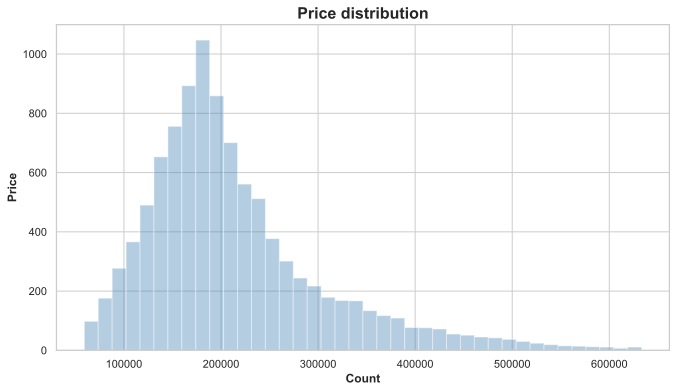

In [193]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

sns.distplot(df_train['Price'], bins = 40, kde = False, color = 'steelblue')

plt.title('Price distribution', fontsize = 16, weight = 'bold')
plt.xlabel('Count', fontsize = 12, weight = 'bold')
plt.ylabel('Price', fontsize = 12, weight = 'bold')

## 2. Предобработка данных

### Тренировочный датасет

In [194]:
df_train = data_prepare(df_train)


Признак Rooms:
	 заменяю сомнительные значения Rooms (больше 10) на медиану

Признак HouseYear:
	 заменяю значения года больше текущего (2020) на медиану

Признаки Floor, HouseFloor:
	Заменяю ошибочные значения (HouseFloor), где (Floor > HouseFloor) на сам этаж квартиры (Floor)

Признаки Square, LifeSquare, KitchenSquare:
	Ввожу новые вспомогательные признаки:                
		- Rate_Square_Life_to_Total    = LifeSquare    / Square                
		- Rate_Square_Kitchen_to_Total = KitchenSquare / Square
	Медиана Rate_Square_Kitchen_to_Total = 0.1390745628960508
	Медиана Rate_Square_Life_to_Total    = 0.6051559467999972

	Замена площадей (менее 6 м2)

Признак Healthcare_1            
	Логика признака непонятна - заполняю пустые значения Healthcare_1 медианой

Категориальные переменные, Dtype = object (Ecology_2, Ecology_3, Shops_2)
	Преобразование к типу int

Ввожу новый взвешенный параметр:                
	 - WeightParam


In [195]:
df_med_price_by_weight_param = df_train.groupby(['WeightParam'], as_index = False).agg({'Price':'median'})\
                                        .rename(columns={'Price':'MedPriceByWeightParam'})

df_med_price_by_weight_param
df_train = df_train.merge(df_med_price_by_weight_param, on = ['WeightParam'], how = 'left')

In [196]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rate_Square_Life_to_Total,Rate_Square_Kitchen_to_Total,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,WeightParam,MedPriceByWeightParam
0,14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969.0,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730,0.613626,0.125048,0,0,0,110.0,196684.316040
1,15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978.0,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0.609734,0.121796,0,0,0,142.0,223622.399270
2,4765,53,2.0,44.947953,29.197612,0.000000,8,12.0,1968.0,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0.649587,0.000000,0,0,0,107.0,218230.696709
3,5809,58,2.0,53.352981,32.286874,6.411281,8,17.0,1977.0,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0.605156,0.120167,0,0,0,81.0,202577.994385
4,10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976.0,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0.599663,0.176548,0,0,0,81.0,202577.994385


In [197]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            10000 non-null  int64  
 1   DistrictId                    10000 non-null  int64  
 2   Rooms                         10000 non-null  float64
 3   Square                        10000 non-null  float64
 4   LifeSquare                    10000 non-null  float64
 5   KitchenSquare                 10000 non-null  float64
 6   Floor                         10000 non-null  int64  
 7   HouseFloor                    10000 non-null  float64
 8   HouseYear                     10000 non-null  float64
 9   Ecology_1                     10000 non-null  float64
 10  Ecology_2                     10000 non-null  object 
 11  Ecology_3                     10000 non-null  object 
 12  Social_1                      10000 non-null  int64  
 13  So

### Тестовый датасет

In [198]:
df_test = data_prepare(df_test)


Признак Rooms:
	 заменяю сомнительные значения Rooms (больше 10) на медиану

Признак HouseYear:
	 заменяю значения года больше текущего (2020) на медиану

Признаки Floor, HouseFloor:
	Заменяю ошибочные значения (HouseFloor), где (Floor > HouseFloor) на сам этаж квартиры (Floor)

Признаки Square, LifeSquare, KitchenSquare:
	Ввожу новые вспомогательные признаки:                
		- Rate_Square_Life_to_Total    = LifeSquare    / Square                
		- Rate_Square_Kitchen_to_Total = KitchenSquare / Square
	Медиана Rate_Square_Kitchen_to_Total = 0.13640698743987703
	Медиана Rate_Square_Life_to_Total    = 0.6071272229591567

	Замена площадей (менее 6 м2)

Признак Healthcare_1            
	Логика признака непонятна - заполняю пустые значения Healthcare_1 медианой

Категориальные переменные, Dtype = object (Ecology_2, Ecology_3, Shops_2)
	Преобразование к типу int

Ввожу новый взвешенный параметр:                
	 - WeightParam


In [199]:
df_test = df_test.merge(df_med_price_by_weight_param, on=['WeightParam'], how='left')
df_test.loc[df_test['MedPriceByWeightParam'] == 0, 'MedPriceByWeightParam'] = df_train['MedPriceByWeightParam'].median()

In [200]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            5000 non-null   int64  
 1   DistrictId                    5000 non-null   int64  
 2   Rooms                         5000 non-null   float64
 3   Square                        5000 non-null   float64
 4   LifeSquare                    5000 non-null   float64
 5   KitchenSquare                 5000 non-null   float64
 6   Floor                         5000 non-null   int64  
 7   HouseFloor                    5000 non-null   float64
 8   HouseYear                     5000 non-null   float64
 9   Ecology_1                     5000 non-null   float64
 10  Ecology_2                     5000 non-null   object 
 11  Ecology_3                     5000 non-null   object 
 12  Social_1                      5000 non-null   int64  
 13  Soc

In [201]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rate_Square_Life_to_Total,Rate_Square_Kitchen_to_Total,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,WeightParam,MedPriceByWeightParam
0,725,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972.0,0.310199,B,B,11,2748,1,900.0,0,0,B,0.670229,0.120282,0,0,0,40.0,154310.613819
1,15856,74,2.0,69.263183,42.051564,1.000000,6,6.0,1977.0,0.075779,B,B,6,1437,3,900.0,0,2,B,0.607127,0.014438,0,0,0,24.0,139732.037911
2,5480,190,1.0,13.597819,8.255606,1.854837,2,5.0,1909.0,0.000000,B,B,30,7538,87,4702.0,5,5,B,0.607127,0.136407,0,0,0,104.0,325093.485064
3,15664,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007.0,0.101872,B,B,23,4583,3,900.0,3,3,B,0.711064,0.123209,0,0,0,66.0,251614.571485
4,14275,27,1.0,47.527111,43.387569,1.000000,17,17.0,2017.0,0.072158,B,B,2,629,1,900.0,0,0,A,0.912901,0.021041,0,0,1,12.0,141175.661199


## 3. Построение модели

### Тренировочный датасет и целевая переменная

In [202]:
# Целевая переменная Price
y = df_train['Price']
y.head(10)

# Признаки - первоначальный список
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'WeightParam', 'MedPriceByWeightParam']
X = df_train[feature_names]

### Разделение тренировочного датасета на учебные и проверочные данные

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Стандартизация (масштабирование) признаков

In [204]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

### Подбор лучших параметров модели

In [205]:
# search_best_params(X_train_scaled, y_train)

In [206]:
# n_estimators_best = 50
# random_state_best = 10
n_estimators_best = 300
random_state_best = 21

### Обучение базовой модели

In [207]:
model = RandomForestRegressor(n_estimators = n_estimators_best, max_features = 6, 
                              criterion = 'mse', random_state = random_state_best)
model.fit(X_train_scaled, y_train)

y_train_preds = model.predict(X_train_scaled)
y_test_preds  = model.predict(X_test_scaled)

print('R2 Train =', r2_score(y_train, y_train_preds))
print('R2 Test  =', r2_score(y_test, y_test_preds))

R2 Train = 0.9646892331184834
R2 Test  = 0.7271537905687202


### Оценка прогноза

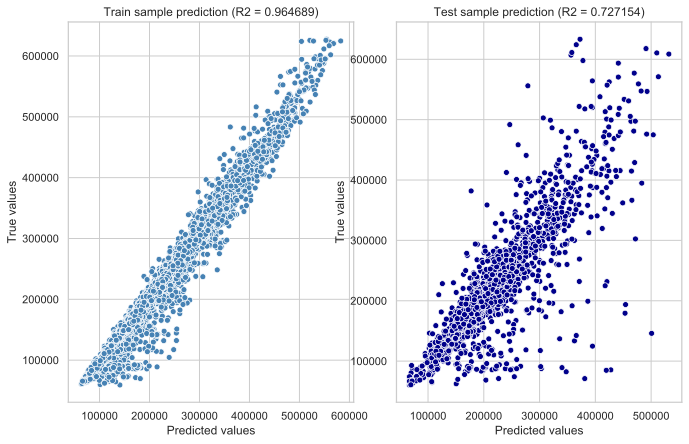

In [208]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Важность признаков

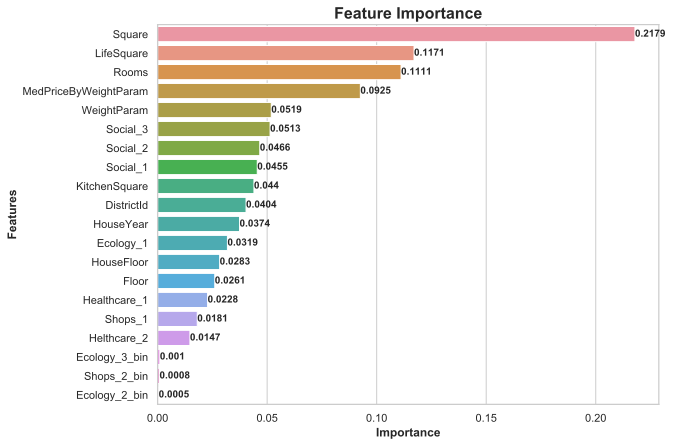

In [209]:
feature_importances = show_features_importance(X_train, model.feature_importances_) 

### Исключение малозначащих признаков из модели

In [210]:
print('Исключение признаков с весом менее 0,5%')
df_del = feature_importances.loc[ feature_importances['Importance'] < 0.005, ['Feature', 'Importance']]
df_del

Исключение признаков с весом менее 0,5%


,Feature,Importance
10,Ecology_3_bin,0.001017
17,Shops_2_bin,0.000844
9,Ecology_2_bin,0.000469


### Построение модели на меньшем количестве признаков

In [211]:
feature_names_top_list = list(feature_importances.loc[feature_importances['Importance'] > 0.005, 'Feature'])
X = df_train[feature_names_top_list]
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state_best)
# 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
# 
model = RandomForestRegressor(n_estimators = n_estimators_best, criterion = 'mse', random_state = random_state_best)
model.fit(X_train_scaled, y_train)

y_train_preds = model.predict(X_train_scaled)
y_test_preds  = model.predict(X_test_scaled)
# 
print('R2 Train =', r2_score(y_train, y_train_preds))
print('R2 Test  =', r2_score(y_test, y_test_preds))

R2 Train = 0.9627308274653477
R2 Test  = 0.7345572970566856


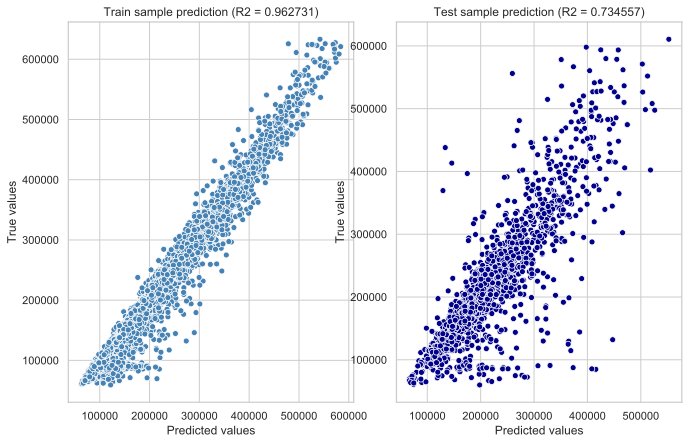

In [212]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Проверка модели 

,R2,Mean
0,0.730676,0.722198
1,0.723178,0.722198
2,0.718786,0.722198
3,0.716153,0.722198


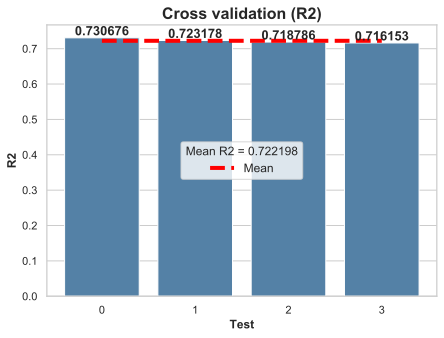

In [213]:
cross_validation_check(model, X, y, 'r2', 4, 10)

## 4. Тестовый датасет

In [214]:
df_task = pd.read_csv('test.csv', sep = ',')

In [215]:
df_task = data_prepare(df_task)


Признак Rooms:
	 заменяю сомнительные значения Rooms (больше 10) на медиану

Признак HouseYear:
	 заменяю значения года больше текущего (2020) на медиану

Признаки Floor, HouseFloor:
	Заменяю ошибочные значения (HouseFloor), где (Floor > HouseFloor) на сам этаж квартиры (Floor)

Признаки Square, LifeSquare, KitchenSquare:
	Ввожу новые вспомогательные признаки:                
		- Rate_Square_Life_to_Total    = LifeSquare    / Square                
		- Rate_Square_Kitchen_to_Total = KitchenSquare / Square
	Медиана Rate_Square_Kitchen_to_Total = 0.13640698743987703
	Медиана Rate_Square_Life_to_Total    = 0.6071272229591567

	Замена площадей (менее 6 м2)

Признак Healthcare_1            
	Логика признака непонятна - заполняю пустые значения Healthcare_1 медианой

Категориальные переменные, Dtype = object (Ecology_2, Ecology_3, Shops_2)
	Преобразование к типу int

Ввожу новый взвешенный параметр:                
	 - WeightParam


In [216]:
df_task = df_task.merge(df_med_price_by_weight_param, on = ['WeightParam'], how = 'left')
df_task.loc[ (df_task['MedPriceByWeightParam'] == 0) | (df_task['MedPriceByWeightParam'].isna()), 'MedPriceByWeightParam'] = \
                df_train['MedPriceByWeightParam'].median()

In [217]:
df_task.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            5000 non-null   int64  
 1   DistrictId                    5000 non-null   int64  
 2   Rooms                         5000 non-null   float64
 3   Square                        5000 non-null   float64
 4   LifeSquare                    5000 non-null   float64
 5   KitchenSquare                 5000 non-null   float64
 6   Floor                         5000 non-null   int64  
 7   HouseFloor                    5000 non-null   float64
 8   HouseYear                     5000 non-null   float64
 9   Ecology_1                     5000 non-null   float64
 10  Ecology_2                     5000 non-null   object 
 11  Ecology_3                     5000 non-null   object 
 12  Social_1                      5000 non-null   int64  
 13  Soc

In [218]:
X_task_test = df_task[feature_names_top_list]

X_task_test_scaled = scaler.transform(X_task_test)
X_task_test_scaled = pd.DataFrame(X_task_test, columns = X_task_test.columns)

In [219]:
y_task_test_preds = model.predict(X_task_test_scaled)

In [220]:
df_save = pd.DataFrame({'Id': df_test['Id'], 'Price': y_task_test_preds}, columns = ['Id', 'Price'])
df_save.head(10)

,Id,Price
0,725,355829.580179
1,15856,348836.809356
2,5480,375948.182390
3,15664,348341.861747
4,14275,341199.987797
5,7633,341466.737223
6,13329,353166.380994
7,5502,348193.635082
8,4220,348154.063577
9,11538,364968.960257


In [221]:
df_save.to_csv('AMishenkov_predictions.csv', sep = ',', index = False)